In [1]:
#pip install tensorflow

In [2]:
#pip install matplotlib

In [3]:
#pip install numpy

In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [5]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCH = 50

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Plant Disease(Potato)",
    shuffle=True,
    image_size= (IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names

In [8]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [9]:
len(dataset)

68

In [10]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 2 1 1 1 0 0 1 0 1 1 0 2 1 0 2 2 0 0 0 0 0 1 1 1 0 1 1 0 0 1]


In [11]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


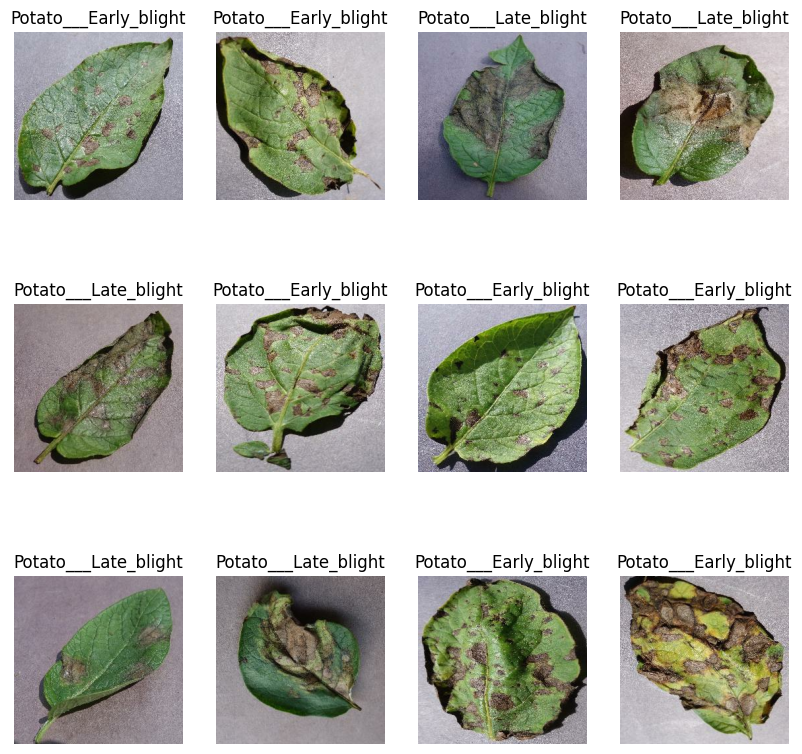

In [12]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [33]:
80% ==> training
20% ==> 10% validation, 10% test

SyntaxError: invalid syntax (829920516.py, line 1)

In [34]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [35]:
train_ds = dataset.take(54)

In [37]:
test_ds = dataset.skip(54)

In [38]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [39]:
val_ds = test_ds.take(6)

In [40]:
test_ds = test_ds.skip(6)

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    test_size = int(test_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

54

In [16]:
len(val_ds)

6

In [17]:
len(test_ds)

8

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
# Pre-processing pipeline
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255)
])

In [20]:
# Random flip and Rotation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [21]:
# Define the model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),  # Input layer specifying the shape
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax"),
])

# Print model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,891 (1.06 MB)

 Trainable params: 277,891 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['Accuracy']
)

In [23]:
history = model.fit(
    train_ds,
    epochs=EPOCH,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - Accuracy: 0.4880 - loss: 0.9126 - val_Accuracy: 0.7188 - val_loss: 0.5902
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 468ms/step - Accuracy: 0.7846 - loss: 0.5210 - val_Accuracy: 0.8542 - val_loss: 0.3407
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 26s 489ms/step - Accuracy: 0.8670 - loss: 0.3247 - val_Accuracy: 0.8958 - val_loss: 0.2325
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 26s 474ms/step - Accuracy: 0.8978 - loss: 0.2714 - val_Accuracy: 0.8646 - val_loss: 0.3947
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 470ms/step - Accuracy: 0.8957 - loss: 0.2485 - val_Accuracy: 0.8854 - val_loss: 0.2782
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 470ms/step - Accuracy: 0.9234 - loss: 0.1810 - val_Accuracy: 0.9375 - val_loss: 0.1266
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 26s 484ms/step - Accuracy: 0.9482 - loss: 0.1350 - val_Accuracy: 0.9688 - val_loss: 0.0776
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 26s 475ms/step - Accuracy: 0.9574 - loss: 0.1211 - val_Accu

In [24]:
history.history.keys()

dict_keys(['Accuracy', 'loss', 'val_Accuracy', 'val_loss'])

In [25]:
acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

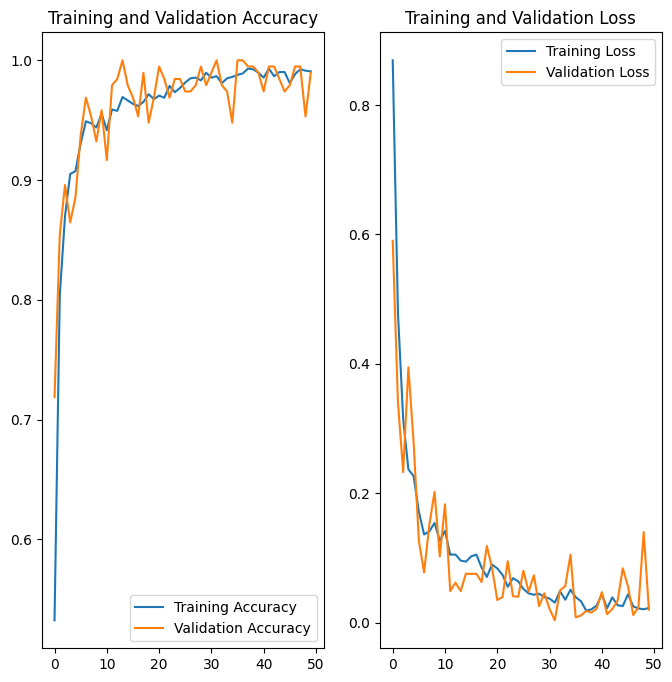

In [26]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCH), acc, label='Training Accuracy')
plt.plot(range(EPOCH), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCH), loss, label='Training Loss')
plt.plot(range(EPOCH), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to Predict
first image actual Label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Predicted Label: Potato___Early_blight


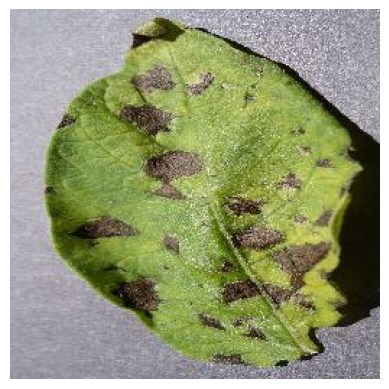

In [27]:
import numpy as np
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    print('first image to Predict')
    plt.imshow(first_image)
    print("first image actual Label:", class_names[first_label])
    plt.axis("off")

batch_prediction = model.predict(image_batch)
print('Predicted Label:', class_names[np.argmax(batch_prediction[0])])

In [28]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Create batch

    prediction = model.predict(img_array)

    Predicted_class = class_names[np.argmax(prediction[0])]
    Confidence = round(100*(np.max(prediction[0])), 2)
    return Predicted_class, Confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


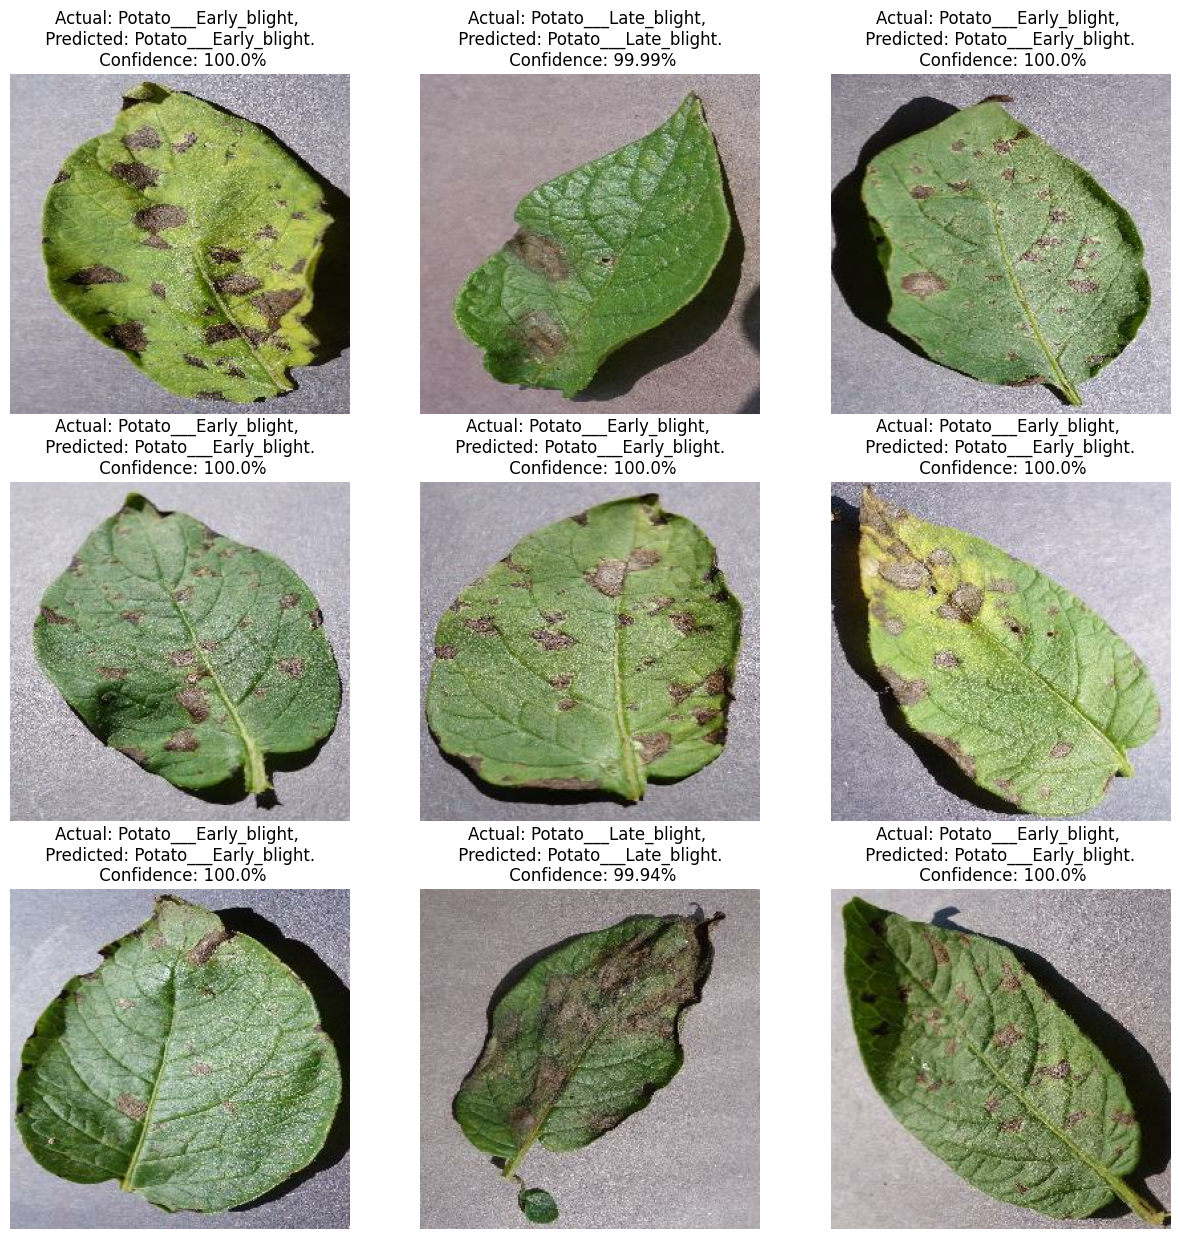

In [29]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        Predicted_class, Confidence = predict(model, images[i].numpy())
        Actual_class = class_names[labels[i]]

        plt.title(f"Actual: {Actual_class}, \n Predicted: {Predicted_class}. \n Confidence: {Confidence}%")
        plt.axis("off")

In [136]:
#model_version = 1
#model.save(f"../models/{model_version}")

In [141]:
#import os
#os.listdir("../models")

['model_1.keras']

In [140]:
#model_version = 1
#model.save(f'../models/model_{model_version}.keras')

In [30]:
import pickle
# Saving model to disk
pickle.dump(model, open('model.pkl','wb'))